In [25]:
import math
import numpy as np
from scipy import constants
import scipy
import matplotlib.pyplot as plt
import mpmath as mp

eta = 1e-3
rho_f = 700
temp = 293

m = 5e-13
K = 1e-6
r = 3e-6

# EQUILIBRIUM HYDRO MSD
def hydro_msd(t):
    trap_const = K
    use_mass = m
    m_f = 2 / 3 * np.pi * r ** 3 * 1000
    t_k = (6 * np.pi * r * eta) / K
    t_f = (rho_f * r ** 2) / eta
    t_p = m / (6 * np.pi * r * eta)
    print(t_p)
    # find roots
    # a * z^4 + b * z^3 + c * z^2 + d * z + e = 0
    a_ = t_p
    b = -1 * np.sqrt(t_f)
    c = 1
    d = 0
    e = 1 / t_k

    # Coefficients array for the polynomial equation
    coefficients = [a_, b, c, d, e]

    # Find the roots
    roots = np.roots(coefficients)

    # I need to learn how to vectorize my code better
    term_1 = scipy.special.erfcx(roots[0] * np.sqrt(t)) / (
                roots[0] * (roots[0] - roots[1]) * (roots[0] - roots[2]) * (roots[0] - roots[3]))
    term_2 = scipy.special.erfcx(roots[1] * np.sqrt(t)) / (
                roots[1] * (roots[1] - roots[0]) * (roots[1] - roots[2]) * (roots[1] - roots[3]))
    term_3 = scipy.special.erfcx(roots[2] * np.sqrt(t)) / (
                roots[2] * (roots[2] - roots[1]) * (roots[2] - roots[0]) * (roots[2] - roots[3]))
    term_4 = scipy.special.erfcx(roots[3] * np.sqrt(t)) / (
                roots[3] * (roots[3] - roots[1]) * (roots[3] - roots[2]) * (roots[3] - roots[0]))

    D = constants.k * temp / (6 * np.pi * eta * r)
    # Returns theoretical MSD
    return np.real(2 * constants.k * temp / trap_const + 2 * constants.k * temp / (use_mass) * (
                term_1 + term_2 + term_3 + term_4))

# VACF WHEN V0=0
def VACF_init_conditions_hydro(t, m, K, r):
    t_k = (6 * math.pi * r * eta) / K
    t_f = (rho_f * r ** 2) / eta
    t_p = m / (6 * math.pi * r * eta)

    # find roots
    # a * z^4 + b * z^3 + c * z^2 + d * z + e = 0

    a = t_p #+ (1 / 9.0) * t_f
    b = -np.sqrt(t_f)
    c = 1
    d = 0
    e = 1 / t_k

    coefficients = [a, b, c, d, e]

    roots = np.roots(coefficients)
    print("roots: " + str(roots))

    term1 = (1/m) * sum(
        (roots[i] ** 3 * scipy.special.erfcx(roots[i] * np.sqrt(t))) /
        (np.prod([roots[i] - roots[j] for j in range(len(roots)) if i != j])) for i in range(len(roots))
    )
    big_a = np.real(term1)
    term2 = (1/m) * sum(
        (z * scipy.special.erfcx(z * np.sqrt(t))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots)
    big_b = np.real(term2)
    az = (1/m) * sum(
        (z ** 3  * scipy.special.erfcx(z * np.sqrt(1e-20))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots
    )
    a_zero = np.real(az)
    bz = (1/m) * sum(
        (z* scipy.special.erfcx(z * np.sqrt(1e-20))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots)
    b_zero = np.real(bz)

    vacf = constants.k * temp * (big_a - m*a_zero*big_a - K*b_zero*big_b)
    return vacf


In [26]:
# POLYNOMIAL ROOTS
def compute_roots(m, K, r):
    t_k = (6 * math.pi * r * eta) / K
    t_f = (rho_f * r ** 2) / eta
    t_p = m / (6 * math.pi * r * eta)

    a = t_p
    b = -np.sqrt(t_f)
    c = 1
    d = 0
    e = 1 / t_k

    coeffs = [a, b, c, d, e]
    return np.roots(coeffs)

# VACF WHEN V0=0
def VACF_for_integral(t1, t2, m, K, roots):
    tau = np.abs(t2 - t1)
    a_diff = (1/m) * sum(
        (z**3 * scipy.special.erfcx(z * np.sqrt(tau))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots)

    a1 = (1/m) * sum(
        (z**3 * scipy.special.erfcx(z * np.sqrt(t1))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots)

    a2 = (1/m) * sum(
        (z**3 * scipy.special.erfcx(z * np.sqrt(t2))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots)

    b1 = (1/m) * sum(
        (z * scipy.special.erfcx(z * np.sqrt(t1))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots)

    b2 = (1/m) * sum(
        (z * scipy.special.erfcx(z * np.sqrt(t2))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots)

    r_term = constants.k * temp * (np.real(a_diff) - m*np.real(a1)*np.real(a2) - K*np.real(b1)*np.real(b2))
    return r_term

# DOUBLE INTEGRAL FUNCTIONS
def integrate_t2(t1, t, m, K, roots):
    return scipy.integrate.quad(lambda t2: VACF_for_integral(t1, t2, m, K, roots), 0, t, epsabs=1e-14, epsrel=1e-14)[0]

def compute_x_squared(t, m, K, roots):
    return scipy.integrate.quad(lambda t1: integrate_t2(t1, t, m, K, roots), 0, t, epsabs=1e-14, epsrel=1e-14)[0]


In [27]:
# NUMERICAL APPROX FOR (g*s^(1/2))/(a*s^(3/2) + b*s^2 + c*s + d)
def numerical_laplace_term3(t_, v0):
    mp.dps = 30  # number of decimal places
    
    pre_factor = (6*math.pi*r**2*math.sqrt(rho_f*eta)) * v0
    
    a = 6*math.pi*r**2*math.sqrt(rho_f*eta)
    b = m
    c = 6*math.pi*r*eta
    d = K
    g = 1
    
    def F(s):
        return g * mp.sqrt(s) / (a*s**(3/2) + b*s**2 + c*s + d)
    
    return pre_factor*np.array(float(mp.invertlaplace(F, t_, method='talbot')) )

def analytic_laplace_term3(t_, v0):
    pre_factor = (6*math.pi*r**2*math.sqrt(rho_f*eta)) * v0
    a = 6*math.pi*r**2*math.sqrt(rho_f*eta)
    b = m
    c = 6*math.pi*r*eta
    d = K
    
    term1 = -a**2*scipy.special.erfcx(a*np.sqrt(t_))/((a-b)*(a-c)*(a-d))
    term2 = b**2*scipy.special.erfcx(b*np.sqrt(t_))/(a-b)
    term3 = c**2*(d-b)*scipy.special.erfcx(c*np.sqrt(t_))/(a-c)
    term4 = d**2*(b-c)*scipy.special.erfcx(d*np.sqrt(t_))/(a-d)
    term5 = (term3+term4)/(c-d)
    term6 = (term2+term5)/((b-c)*(b-d))
    return pre_factor*(term1 + term6)
    
    

In [28]:
# VACF FOR VARIABLE INITIAL VELOCITY
def VACF_for_var_init_integral_numerical(t1, t2, m, K, roots, v0=np.sqrt(constants.k*temp/m)):
    tau = np.abs(t2 - t1)
    a_diff = (1/m) * sum(
        (z**3 * scipy.special.erfcx(z * np.sqrt(tau))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots)

    a1 = (1/m) * sum(
        (z**3 * scipy.special.erfcx(z * np.sqrt(t1))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots)

    a2 = (1/m) * sum(
        (z**3 * scipy.special.erfcx(z * np.sqrt(t2))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots)

    b1 = (1/m) * sum(
        (z * scipy.special.erfcx(z * np.sqrt(t1))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots)

    b2 = (1/m) * sum(
        (z * scipy.special.erfcx(z * np.sqrt(t2))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots)

    r_term = constants.k * temp * (np.real(a_diff) - m*np.real(a1)*np.real(a2) - K*np.real(b1)*np.real(b2))
    # return r_term
    inertial_init_term = v0**2 * m**2 * np.real(a1) * np.real(a2)
    numerical_term = numerical_laplace_term3(t1, v0) * numerical_laplace_term3(t2, v0)
    return r_term + inertial_init_term + numerical_term

def VACF_for_var_init_integral_analytical(t1, t2, m, K, roots, v0=np.sqrt(constants.k*temp/m)):
    tau = np.abs(t2 - t1)
    a_diff = (1/m) * sum(
        (z**3 * scipy.special.erfcx(z * np.sqrt(tau))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots)

    a1 = (1/m) * sum(
        (z**3 * scipy.special.erfcx(z * np.sqrt(t1))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots)

    a2 = (1/m) * sum(
        (z**3 * scipy.special.erfcx(z * np.sqrt(t2))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots)

    b1 = (1/m) * sum(
        (z * scipy.special.erfcx(z * np.sqrt(t1))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots)

    b2 = (1/m) * sum(
        (z * scipy.special.erfcx(z * np.sqrt(t2))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots)

    r_term = constants.k * temp * (np.real(a_diff) - m*np.real(a1)*np.real(a2) - K*np.real(b1)*np.real(b2))
    # return r_term
    inertial_init_term = v0**2 * m**2 * np.real(a1) * np.real(a2)
    numerical_term = analytic_laplace_term3(t1, v0) * analytic_laplace_term3(t2, v0)
    return r_term + inertial_init_term + numerical_term

def integrate_t2_var_n(t1, t, m, K, roots, v0):
    return scipy.integrate.quad(lambda t2: VACF_for_var_init_integral_numerical(t1, t2, m, K, roots, v0), 0, t, epsabs=1e-14, epsrel=1e-14)[0]

def compute_x_squared_var_n(t, m, K, roots, v0):
    return scipy.integrate.quad(lambda t1: integrate_t2_var_n(t1, t, m, K, roots, v0), 0, t, epsabs=1e-14, epsrel=1e-14)[0]


def integrate_t2_var_a(t1, t, m, K, roots, v0):
    return scipy.integrate.quad(lambda t2: VACF_for_var_init_integral_analytical(t1, t2, m, K, roots, v0), 0, t, epsabs=1e-14, epsrel=1e-14)[0]

def compute_x_squared_var_a(t, m, K, roots, v0):
    return scipy.integrate.quad(lambda t1: integrate_t2_var_a(t1, t, m, K, roots, v0), 0, t, epsabs=1e-14, epsrel=1e-14)[0]
    

In [29]:
times = np.logspace(-7, -3, 6)
roots = compute_roots(m, K, r)

# EQ MSD
basset_msd = hydro_msd(times)

# V0 = 0 MSD
init_zero_msd = []

for t in times:
    print(f"t = {t:.2e}")
    val = compute_x_squared(t, m, K, roots)
    init_zero_msd.append(val)

8.841941282883075e-06
t = 1.00e-07
t = 6.31e-07
t = 3.98e-06
t = 2.51e-05
t = 1.58e-04
t = 1.00e-03


In [30]:
# VARIABLE V0 HYDRO MSD

# Set v0
v0 = 0
v02 = np.sqrt(constants.k*temp/m)
v03 = np.sqrt(constants.k*temp/m)/3

init_var_hydro_msd = []

for t in times:
    print(f"t = {t:.2e}")
    val2 = compute_x_squared_var_a(t, m, K, roots, v0)
    init_var_hydro_msd.append(val2)
    

init_var_hydro_msd2 = []

for t in times:
    print(f"t = {t:.2e}")
    val2 = compute_x_squared_var_a(t, m, K, roots, v02)
    init_var_hydro_msd2.append(val2)
    
    
# init_var_hydro_msd3 = []
# 
# for t in times:
#     print(f"t = {t:.2e}")
#     val2 = compute_x_squared_var_n(t, m, K, roots, v03)
#     init_var_hydro_msd3.append(val2)
    
init_var_hydro_msd4 = []

for t in times:
    print(f"t = {t:.2e}")
    val2 = compute_x_squared_var_a(t, m, K, roots, v03)
    init_var_hydro_msd4.append(val2)

t = 1.00e-07
t = 6.31e-07
t = 3.98e-06
t = 2.51e-05
t = 1.58e-04
t = 1.00e-03
t = 1.00e-07
t = 6.31e-07
t = 3.98e-06
t = 2.51e-05
t = 1.58e-04
t = 1.00e-03
t = 1.00e-07
t = 6.31e-07
t = 3.98e-06
t = 2.51e-05
t = 1.58e-04
t = 1.00e-03
t = 1.00e-07
t = 6.31e-07
t = 3.98e-06
t = 2.51e-05
t = 1.58e-04
t = 1.00e-03


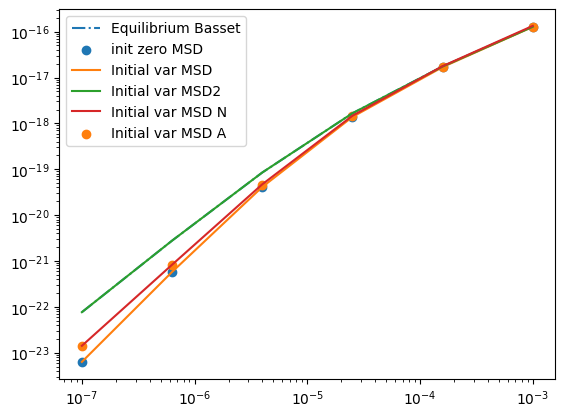

In [31]:
#PLOT MSDS
plt.plot(times[:30], basset_msd[:30], linestyle='dashdot', label="Equilibrium Basset")
plt.scatter(times[:30], init_zero_msd[:30], label="init zero MSD")
plt.plot(times, init_var_hydro_msd, label="Initial var MSD")
plt.plot(times, init_var_hydro_msd2, label="Initial var MSD2")
plt.plot(times, init_var_hydro_msd3, label="Initial var MSD N")
plt.scatter(times, init_var_hydro_msd4, label="Initial var MSD A")
plt.xscale("log")
plt.yscale("log")
plt.legend()

roots: [ 1.41958228e+02+304.8608164j   1.41958228e+02-304.8608164j
 -2.21985614e-02  +4.20525672j -2.21985614e-02  -4.20525672j]


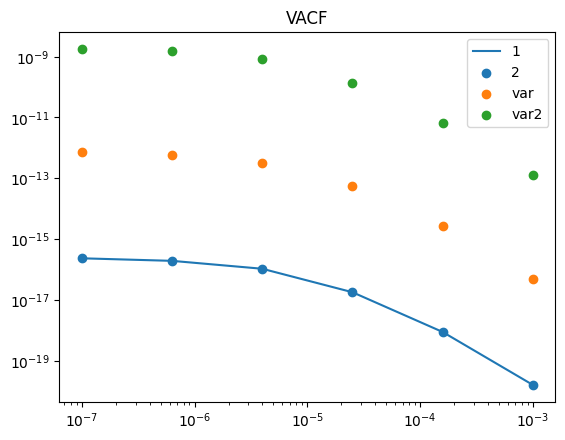

In [32]:
# Calculate VACF
vacf_z = VACF_init_conditions_hydro(times, m, K, r)
vacf_z2 = []
vacf_var1 = []
vacf_var2 = []

for t in times:
    z2 = VACF_for_integral(1e-20, t, m, K, roots)
    var1 = VACF_for_var_init_integral_analytical(1e-20, t, m, K, roots, v0=(np.sqrt(scipy.constants.k*temp/m))/100)
    vacf_var1.append(var1)
    var2 = VACF_for_var_init_integral_analytical(1e-20, t, m, K, roots, v0=(np.sqrt(scipy.constants.k*temp/m))/2)
    vacf_var2.append(var2)
    vacf_z2.append(z2)
    
# PLOT VACFs

plt.plot(times, vacf_z, label="1")
plt.scatter(times, vacf_z2, label="2")
plt.scatter(times, vacf_var1, label="var")

plt.scatter(times, vacf_var2, label="var2")
plt.title('VACF')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()